In [12]:
%pwd #현재 실행중인 위치 확인

'/Users/hx/Env'

### 환경 구성

In [13]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
# GPU 설정, mac os만
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) #그래픽 카드 용량만큼 확장?ㅇ
    print("GPU is available")
else:
    print("GPU is not available, using CPU")
    
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

GPU is available


### Simple CNN

#### load, prepro, split

In [20]:
def load_and_preprocess_data(base_dir, img_size=(299,299)): # 전체 데이터를 불러오고 전처리하는 함수 만들기(불러올 데이터, 이미지 사이즈 지정=(,))
    images = [] # image data를 모으는 빈 리스트 생성
    labels = [] # label data를 모으는 빈 리스트 생성
    categories = ['Normal','PNEUMONIA'] # 카테고리 분류 (3~4개면 3~4개의 카테고리 써넣기)
    
    for category in categories :                                        # 각 class에서 500개만 추출하기 위해 반복문 사용
        class_num = categories.index(category)                          # categories의 class에 할당된 index값 가져오기
        base_path = os.path.join(base_dir, category)                    # 파일의 path(접근경로) 지정
        base_files = os.listdir(base_path)                              # 파일 리스트 생성
        print(base_files)
        np.random.shuffle(base_files)                                   # 파일 순서 섞기
        for idx in range(500):                                          # 임의의 데이터 500개 선정
          image_path = os.path.join(base_path, base_files[idx])         # 파일 path(접근경로) 지정
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)          # (경로, 이미지를 grayscale로 불러옴) -> 그리고 image에 저장
          image = cv2.resize(image, img_size)                           # img_size만큼 image resize시킴 -> 그리고 image에 저장
          images.append(image)                                          # images 리스트에 image 추가
          labels.append(class_num)                                      # labels 리스트에 class_num 추가

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)  # images를 list타입에서 array로 변환
                                                                        # 배열 형식 바꿈 (-1 : 배열 크기 자동 계산(개수), 1차원
                                                                        #              img_size[0] : 이미지 높이, 2차원
                                                                        #              img_size[1] : 이미지 넓이, 3차원
                                                                        #              1 : 채널 수, 1=grayscale), 4차원
    return images, np.array(labels)                                     # labes리스트를 넌파이 배열로 변환한 값과 images 값을 반환

def split_data(X, y, test_size=0.2, val_size=0.5): #데이터 분할 함수 생성
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42) 
    # 훈련 데이터 + (검증/테스트) 데이터로 분할
    # stratify : 클래스의 비율을 맞춰서 분할 / 전체데이터의 20%를 test와 train함수로 나눠 저장
    # 전체 데이터에서 test_size 비율만큼을 떼어 X_val_test와 y_val_test로 나누고, 나머지는 X_train과 y_train으로 나눔.
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=val_size, stratify=y_val_test, random_state=42) 
    # (검증/테스트)를 검증 + 테스트로 분할
    # val_size 비율에 따라 다시 train과 val_test로 나누기
    # X_val_test와 y_val_test를 val_size 비율로 다시 나누어 X_val과 X_test, y_val과 y_test로 분할.
    return X_train, y_train, X_val, y_val, X_test, y_test # 최종적으로 나뉜 데이터셋 반환


In [21]:
base_dir = 'Pneumonia/train' #드라이브의 개인 파일 경로 작성

X, y = load_and_preprocess_data(base_dir)                         # load_and_process_data함수에 base_dir를 넣어 처리후 X, y에 저장
                                                                  # images 값과 np.array(labels) 값이 저장되겠죠 ?

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # X, y 데이터를 받아 train, val, test 셋으로 나누기

print("데이터 로딩 및 전처리 완료") 
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")  
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")     
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")    

['NORMAL2-IM-0927-0001.jpeg', 'NORMAL2-IM-1056-0001.jpeg', 'IM-0427-0001.jpeg', 'NORMAL2-IM-1260-0001.jpeg', 'IM-0656-0001-0001.jpeg', 'IM-0561-0001.jpeg', 'NORMAL2-IM-1110-0001.jpeg', 'IM-0757-0001.jpeg', 'NORMAL2-IM-1326-0001.jpeg', 'NORMAL2-IM-0736-0001.jpeg', 'NORMAL2-IM-0500-0001.jpeg', 'NORMAL2-IM-0393-0001.jpeg', 'NORMAL2-IM-0994-0001.jpeg', 'IM-0207-0001.jpeg', 'IM-0494-0001.jpeg', 'IM-0177-0001.jpeg', 'IM-0388-0001.jpeg', 'IM-0341-0001.jpeg', 'IM-0355-0001.jpeg', 'IM-0449-0001.jpeg', 'IM-0480-0001.jpeg', 'NORMAL2-IM-1038-0001.jpeg', 'NORMAL2-IM-1348-0001.jpeg', 'IM-0739-0001.jpeg', 'IM-0213-0001.jpeg', 'NORMAL2-IM-0452-0001.jpeg', 'NORMAL2-IM-0980-0001.jpeg', 'NORMAL2-IM-0949-0001.jpeg', 'NORMAL2-IM-0664-0001.jpeg', 'NORMAL2-IM-1332-0001.jpeg', 'IM-0269-0001.jpeg', 'NORMAL2-IM-1104-0001.jpeg', 'IM-0575-0001.jpeg', 'IM-0605-0001.jpeg', 'NORMAL2-IM-1274-0001.jpeg', 'IM-0433-0001.jpeg', 'IM-0119-0001.jpeg', 'NORMAL2-IM-0875-0001.jpeg', 'NORMAL2-IM-0428-0001.jpeg', 'NORMAL2-IM-093

#### create

In [22]:
def create_simple_cnn(input_shape):                                     # CNN 만들기 ~
    model = Sequential([                                                # 모델은 Sequential, 레이어 순차적으로 쌓아올림
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 32개의 필터, 필터 크기 3x3, relu 활성화 함수 사용, input_shape의 특징 추출
        MaxPooling2D((2, 2)),                                           # MaxPooling2D레이어(1), 2X2 풀링적용해서 이미지 크기 줄임
        Conv2D(64, (3, 3), activation='relu'),                          # 64개의 필터, 필터 크기 2x2, relu 활성화 함수 사용
        MaxPooling2D((2, 2)),                                           # MaxPooling2D레이어(2), 2X2 풀링적용해서 이미지 크기 줄임
        Conv2D(64, (3, 3), activation='relu'),                          # 64개의 필터, 필터 크기 3x3, relu 활성화 함수 사용
        Flatten(),                                                      # 1차원 배열로 전환 (Dense에 넣기 위해)
        Dense(64, activation='relu'),                                   # 완전 연결 계층 추가, 64개의 유닛, relu 활성화 함수 사용
        Dense(1, activation='sigmoid')                                  # 최종 완전 연결 계층, 1개의 유닛, sigmoid 활성화 함수 사용 
    ])
    return model                                                        # model 생성

 #sigmoid : 이진 함수 binary, 하나에 대한 예측값만 출력하면 됨, 여러개면 Dense(2,activation='softmax').model.compile(~~~,loss='sparse_crossentropy')

#### Compile
- 모델 학습 전, compile() 함수를 사용하여 모델의 손실 함수(loss), 최적화 방법(optimizer), 평가 지표(metrics)를 설정

In [23]:
input_shape = (299, 299, 1)                 #resize 값과 동일하게, 1은 채널값 (gray=1)

model = create_simple_cnn(input_shape)      # 함수를 이용해서 모델 구축

model.compile(optimizer='adam',             # 최적화 방법 모델로 Adam 사용
              loss='binary_crossentropy',   # sigmoid를 썼으니 손실 함수 사용
              metrics=['accuracy'])         # 평가 지표 = accuracy(정확도)

early_stopping = EarlyStopping(             # 특정 조건을 만족하면 자동으로 만료
    monitor='val_loss',                     # 'val_loss'값으로 모니터링
    patience=10,                            # 10번 동안 val_loss가 변화가 없는 것 같다면 멈춤, 정체가 왔을 때 스탑하는걸 방지하려면 patience 값 바꾸면 됨
    verbose=1,                              # 결과값 출력
    mode='min',                             # val_loss를 최소화하는 방향으로 설정
    restore_best_weights=True               # 가장 좋은 가중치 저장
)

model_checkpoint = ModelCheckpoint(         # 모델이 학습하는 동안 가중치 저장
    'best_model.h5',                        # 모델을 저장할 파일 경로
    monitor='val_accuracy',                 # 'val_accuracy'값으로 모니터링
    mode='max',                             # 'val_accuracy'가 최대가 되도록 하는 방향으로 설정
    verbose=1,                              # 결과값 출력
    save_best_only=True                     # 가장 성능이 좋았던 모델 저장
)
                                        
model.summary()                             # 요약

#input shape을 봐야 하고, output shape을 활용해 pooling이 제대로 되고 있는지 확인해야 함
# early stop, model_check point -> overfitting 방지

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-09 22:58:25.687639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-09 22:58:25.689604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

#### 모델 학습

In [24]:
history = model.fit(                                # 훈련데이터 fit시키기
    X_train, y_train,                               # fit 시킬 데이터
    validation_data=(X_val, y_val),                 # 짝 지어주기
    epochs=100,                                     # 100번 돌아가여~, 그 동안 성능 좋은게 나오면 stop. earliystop과 checkpoint 설정을 안 하면 overfitting 생길 수 있음.
    batch_size=32,                                  # 한 epoch에 32개씩, 메모리가 넘 부담되면 batch size 줄임
    callbacks=[early_stopping, model_checkpoint]    # early_stopping과 model_checkpoint를 callbacks에 저장
)

model = tf.keras.models.load_model('best_model.h5') # 가중치 값 저장하는 확장명, 학습 후 가장 높은 성능을 나타내는 가중치 load

Epoch 1/100


2024-07-09 23:35:14.181671: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-09 23:35:14.755483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 123.1073 - accuracy: 0.7337

2024-07-09 23:35:23.858595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to best_model.h5
25/25 [==============================] - 11s 383ms/step - loss: 123.1073 - accuracy: 0.7337 - val_loss: 0.2764 - val_accuracy: 0.9000
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.8712
Epoch 2: val_accuracy improved from 0.90000 to 0.91000, saving model to best_model.h5
25/25 [==============================] - 8s 310ms/step - loss: 0.5856 - accuracy: 0.8712 - val_loss: 0.4045 - val_accuracy: 0.9100
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9525
Epoch 3: val_accuracy did not improve from 0.91000
25/25 [==============================] - 7s 293ms/step - loss: 0.1285 - accuracy: 0.9525 - val_loss: 0.3501 - val_accuracy: 0.9000
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9688
Epoch 4: val_accuracy improved from 0.91000 to 0.94000, saving model to best_model.h5
25/25 [=====

val_loss 줄어듦 -> 학습 개선중임(한번씩 튈 수 있음 ) val_accuracy -> 왔다갔다 하면서 성능 개선 중 4 epoch에서 best model 찾음

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test) # X_test,y_test데이터에 대한 손실값과 평가지표를 각각 test_loss(손실값), test_acc(정확도)에 반환
print(f"Test Accuracy: {test_acc:.4f}")              # 정확도 출력 (소수점 4번째까지)

2024-07-09 23:39:07.046432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 100ms/step - loss: 0.5938 - accuracy: 0.8400
Test Accuracy: 0.8400


In [26]:
y_pred = model.predict(X_test)                      # 테스트 데이터셋에 대해 모델을 사용하여 예측 수행
y_pred_classes = (y_pred>0.5).astype(int).flatten() # 예측된 확률을 이진 클래스 레이블로 변환

1/4 [======>.......................] - ETA: 0s

2024-07-09 23:42:10.757381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 242ms/step


#### Visualization

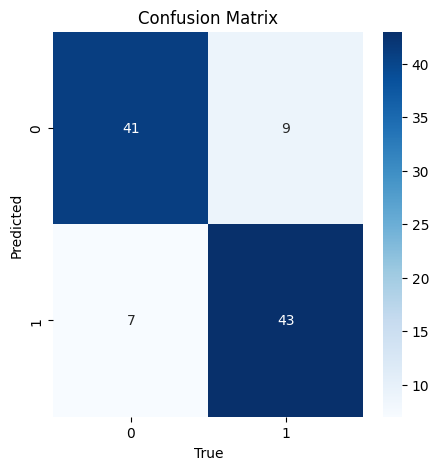

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5))                             # 그래프의 사이즈(가로, 세로)를 조절함. 단위는 inch
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues' ) # heatmap : 빈도수 높을수록 색 찐해짐
plt.title("Confusion Matrix")                         # 그래프 제목: Confusion Matrix
plt.xlabel('True')                                    # x축 label: True
plt.ylabel('Predicted')                               # y축 label: Predicted
plt.show()                                            # 그래프를 화면에 출력

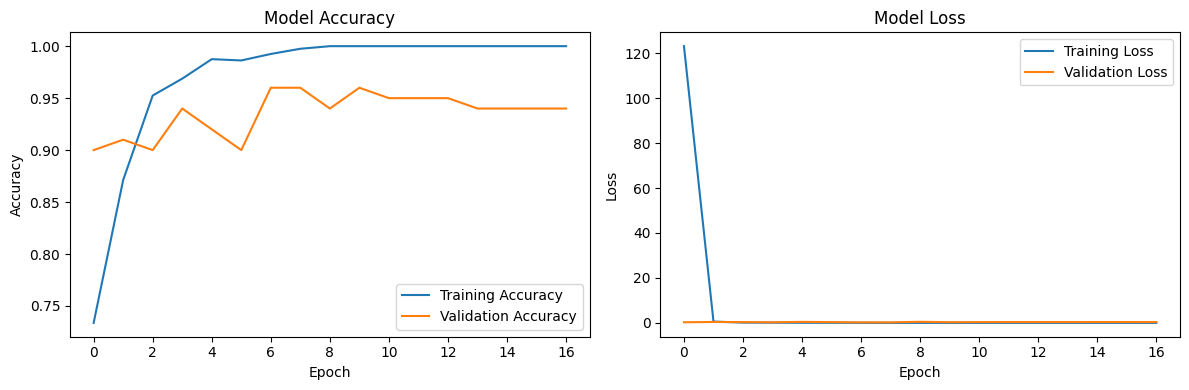

In [28]:
plt.figure(figsize=(12, 4))                                              # 가로 12, 세로 4인 그림 생성
plt.subplot(1, 2, 1)                                                     # subplot의 index는 1부터 2,3,4... 순으로 진행됨 
                                                                         # (0부터 시작되는 파이썬의 인덱싱과 다른 방식임)
plt.plot(history.history['accuracy'], label='Training Accuracy')         # 훈련 정확도 변화를 나타내는 그래프 생성
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')   # 검증 정확도 변화를 나타내는 그래프 생성
plt.title('Model Accuracy')                                              # 그래프 제목: Model Accuracy
plt.xlabel('Epoch')                                                      # x축 label: Epoch
plt.ylabel('Accuracy')                                                   # y축 label: Accuracy
plt.legend()                                                             # 범례 추가

plt.subplot(1, 2, 2)                                                     # 두 개의 subplot중 두번째 subplot 설정
plt.plot(history.history['loss'], label='Training Loss')                 # 훈련 손실 변화를 나타내는 그래프 생성
plt.plot(history.history['val_loss'], label='Validation Loss')           # 검증 손실 변화를 나타내는 그래프 생성
plt.title('Model Loss')                                                  # 그래프 제목: Model Loss
plt.xlabel('Epoch')                                                      # x축 label: Epoch
plt.ylabel('Loss')                                                       # y축 label: Loss
plt.legend()                                                             # 범례 추가

plt.tight_layout() # 간격 조정
plt.show()         # 그래프 보여주삼

- f1  score?
- training accuracy <-> val 사이의 갭 자체가 overfitting을 나타냄 -> 어떻게 줄일까?
- pnumonia 데이터를 주고, 학습시킨거임!
- 이런 경우, 사람과 인공지능 중 어느 것이 더 효율적일까?
- 쓰는 목적에 대해 명확하게 인지해야 함.

### Inception V3
- pretrained model : 이미 잘 만들어진 가중치로 학습한다.

In [29]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam